# Models

In [71]:
import time
import datetime
import numpy as np
import pandas as pd
from statsmodels.discrete.discrete_model import Logit
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, ClassifierMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from pprint import pprint
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [72]:
# %run /content/drive/MyDrive/DentistDataAnalysis/Experiments/Mappings.ipynb
%run Mappings.ipynb

In [73]:
# DIR = '/content/drive/MyDrive/DentistDataAnalysis/Experiments/'
DIR = ''

In [74]:
data = pd.read_csv(DIR+'dataset/final_data.csv')

In [75]:
X_cols = ['Que1', 'Que2', 'Que3', 'Que4', 'Que5', 'Que6', 'Que10_a', 'Que10_b', 'Que10_c', 'Que10_d', 'Que10_e', 'Que10_f', 'Que14', 'Que15', 'Que17', 'Que18_age', 'Que19', 'Que20', 'Que21', 'Que22', 'Que_smoking']
y_col = ['Que16']

## Logit

In [76]:
class SMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        yhat = self.results_.predict(X)
        return list(map(round, yhat))

In [77]:
def perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col):
    X_train_df = pd.DataFrame(data=X_train, columns=X_cols)
    y_train_df = pd.DataFrame(data=y_train, columns=y_col)
    logit_model = SMWrapper(sm.Logit)
    scores = cross_val_score(logit_model, X_train_df, y_train_df, cv=5, n_jobs=-1)
    print('Mean cross-validation score: ')
    print(scores.mean())
    X_train_df = sm.add_constant(X_train_df)
    logit = Logit(y_train_df, X_train_df)
    lg = logit.fit()
    print(lg.summary())
    X_test = sm.add_constant(X_test)
    yhat = lg.predict(X_test)
    prediction = list(map(round, yhat))
    get_metrics(y_test, prediction)   

## Random forest

In [78]:
def perform_random_forest(X_train, y_train, X_test, y_test):
    #hyperparameters config
    n_estimators = [int(x) for x in np.linspace(start = 5, stop = 150, num = 15)]
    criterion = ['gini', 'entropy']
    max_features = ['sqrt']
    max_depth = [int(x) for x in np.linspace(10, 100, num = 6)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True]
    random_grid = {'n_estimators': n_estimators,
                   'criterion': criterion,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    #grid search config
    rf_scoring='accuracy'
    rf_cv = 5
    rf_verbose=1
    rf_n_jobs=-1
    rf_return_train_score=True
    rf = RandomForestClassifier()
    rf_grid = GridSearchCV(estimator=rf, 
                            param_grid=random_grid,
                            scoring=rf_scoring, cv=rf_cv, 
                            verbose=rf_verbose, n_jobs=rf_n_jobs, 
                            return_train_score=rf_return_train_score)
    start_time = time.time()
    rf_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    pprint(rf_grid.best_params_)
    prediction = rf_grid.best_estimator_.predict(X_test)
    get_metrics(y_test, prediction)
    
    start_time = time.time()
    importances = rf_grid.best_estimator_.feature_importances_
    std = np.std([rf_grid.best_estimator_.feature_importances_ for tree in rf_grid.best_estimator_.estimators_], axis=0)
    elapsed_time = time.time() - start_time
    print(f"Elapsed time to compute the importances: " 
          f"{elapsed_time:.3f} seconds")
    forest_importances = pd.Series(importances, index=X_cols)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

## Decision trees

In [79]:
def perform_decision_tree(X_train, y_train, X_test, y_test):
    #hyperparameters config
    criterion = ['gini', 'entropy']
    splitter = ['best', 'random']
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(10, 50, num = 6)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    random_grid = {'criterion': criterion,
                   'splitter': splitter,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    #decision trees config
    dtc_scoring='accuracy'
    dtc_cv = 5
    dtc_verbose=1
    dtc_n_jobs=-1
    dtc_return_train_score=True
    dtc = DecisionTreeClassifier()
    dtc_grid = GridSearchCV(estimator=dtc, 
                            param_grid=random_grid,
                            scoring=dtc_scoring, cv=dtc_cv, 
                            verbose=dtc_verbose, n_jobs=dtc_n_jobs, 
                            return_train_score=dtc_return_train_score)
    start_time = time.time()
    dtc_grid.fit(X_train, y_train)
    end_time = time.time()
    conv_time = datetime.timedelta(seconds=end_time-start_time)
    print(f"Grid search time: {conv_time}")
    
    pprint(dtc_grid.best_params_)
    prediction = dtc_grid.best_estimator_.predict(X_test)
    get_metrics(y_test, prediction)

## Metrics

In [80]:
def get_metrics(y_true, prediction):
    print(np.unique(y_true, return_counts=True))
    print('Test ROC AUC:\t', roc_auc_score(y_true, prediction))
    print('Test accuracy:\t', accuracy_score(y_true, prediction))
    print('Test precision:\t', precision_score(y_true, prediction))
    print('Test recall:\t', recall_score(y_true, prediction))
    print('Test F1 score:\t', f1_score(y_true, prediction))
    print('Test confusion matrix:\t')
    print(confusion_matrix(y_true, prediction))

# Strategy 1 - dropping all missing

In [81]:
data_dropped = data.dropna().reset_index(drop=True)
data_dropped = perform_mapping(data_dropped, questions_map_EN)
model_data = data_dropped.drop(columns=['Que16'])
target_data = data_dropped['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [82]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.684572706935123
Optimization terminated successfully.
         Current function value: 0.563189
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  748
Model:                          Logit   Df Residuals:                      726
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1368
Time:                        17:51:45   Log-Likelihood:                -421.27
converged:                       True   LL-Null:                       -488.02
Covariance Type:            nonrobust   LLR p-value:                 2.260e-18
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.7646      0.285     -2.679      0.007   

### Undersampling

In [83]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
nan
Optimization terminated successfully.
         Current function value: 0.590972
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  536
Model:                          Logit   Df Residuals:                      514
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1474
Time:                        17:51:46   Log-Likelihood:                -316.76
converged:                       True   LL-Null:                       -371.53
Covariance Type:            nonrobust   LLR p-value:                 5.726e-14
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5017      0.346     -4.342      0.000      -2.180     

### Oversampling

In [84]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6864583333333334
Optimization terminated successfully.
         Current function value: 0.592887
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  960
Model:                          Logit   Df Residuals:                      938
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1446
Time:                        17:51:49   Log-Likelihood:                -569.17
converged:                       True   LL-Null:                       -665.42
Covariance Type:            nonrobust   LLR p-value:                 1.076e-29
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.4171      0.257     -5.522      0.000  

### SMOTEENN

In [85]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.8635539064110492
Optimization terminated successfully.
         Current function value: 0.324453
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                  491
Model:                          Logit   Df Residuals:                      469
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.5054
Time:                        17:51:50   Log-Likelihood:                -159.31
converged:                       True   LL-Null:                       -322.10
Covariance Type:            nonrobust   LLR p-value:                 1.922e-56
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.6662      0.720     -6.478      0.000  

## Random Forest

### No balance

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:02:52.326870
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 56}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.7004935596484894
Test accuracy:	 0.7340425531914894
Test precision:	 0.7596899224806202
Test recall:	 0.8376068376068376
Test F1 score:	 0.7967479674796747
Test confusion matrix:	
[[40 31]
 [19 98]]
Elapsed time to compute the importances: 0.219 seconds


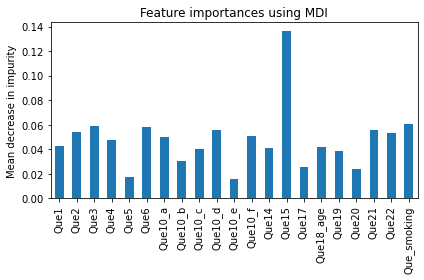

In [63]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:02:40.307966
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 67}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.6824364993379077
Test accuracy:	 0.6702127659574468
Test precision:	 0.7956989247311828
Test recall:	 0.6324786324786325
Test F1 score:	 0.7047619047619047
Test confusion matrix:	
[[52 19]
 [43 74]]
Elapsed time to compute the importances: 0.297 seconds


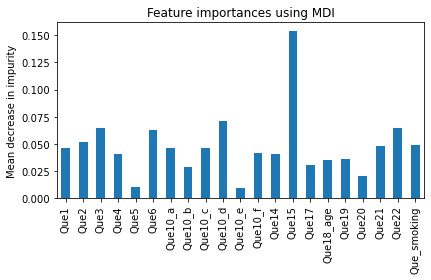

In [64]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:02:56.211140
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.6394005055976887
Test accuracy:	 0.6648936170212766
Test precision:	 0.725
Test recall:	 0.7435897435897436
Test F1 score:	 0.7341772151898733
Test confusion matrix:	
[[38 33]
 [30 87]]
Elapsed time to compute the importances: 0.046 seconds


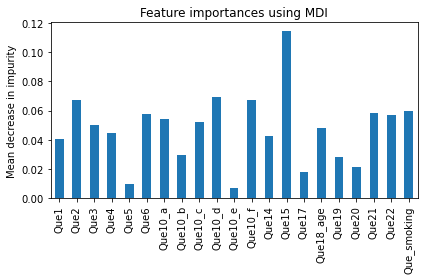

In [65]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:02:35.174726
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 25}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.7007945106536656
Test accuracy:	 0.6861702127659575
Test precision:	 0.8152173913043478
Test recall:	 0.6410256410256411
Test F1 score:	 0.7177033492822967
Test confusion matrix:	
[[54 17]
 [42 75]]
Elapsed time to compute the importances: 0.045 seconds


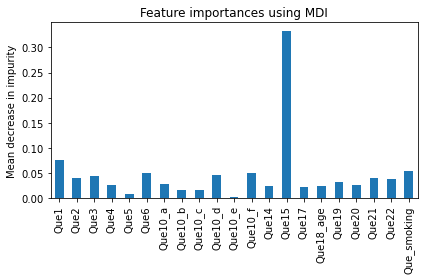

In [66]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [67]:
perform_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:01.021222
{'criterion': 'gini',
 'max_depth': 26,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.6378957505718068
Test accuracy:	 0.6595744680851063
Test precision:	 0.7264957264957265
Test recall:	 0.7264957264957265
Test F1 score:	 0.7264957264957265
Test confusion matrix:	
[[39 32]
 [32 85]]


### Undersampling

In [68]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:00.963314
{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'best'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.613277958348381
Test accuracy:	 0.6117021276595744
Test precision:	 0.7244897959183674
Test recall:	 0.6068376068376068
Test F1 score:	 0.6604651162790697
Test confusion matrix:	
[[44 27]
 [46 71]]


### Oversampling

In [69]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:01.064523
{'criterion': 'gini',
 'max_depth': 34,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.5956422294450464
Test accuracy:	 0.6276595744680851
Test precision:	 0.6910569105691057
Test recall:	 0.7264957264957265
Test F1 score:	 0.7083333333333334
Test confusion matrix:	
[[33 38]
 [32 85]]


### SMOTEENN

In [70]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:00.984859
{'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
(array([0., 1.]), array([ 71, 117]))
Test ROC AUC:	 0.6155651859877211
Test accuracy:	 0.5904255319148937
Test precision:	 0.75
Test recall:	 0.5128205128205128
Test F1 score:	 0.6091370558375634
Test confusion matrix:	
[[51 20]
 [57 60]]
Optimization terminated successfully.
         Current function value: 0.566430
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.583155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.285674
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.562971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339525
         Iterations 8
Optimization

/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_19047/1181320327.py", line 10, in fit
  File "/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py", line 1980, in fit
    **kwargs)
  File "/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py", line 233, in 

# Strategy 2 - median

In [86]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
data_median = pd.DataFrame(imputer.fit_transform(data))
data_median.columns = data.columns
data_median.index = data.index
data_median = perform_mapping(data_median, questions_map_EN)
model_data = data_median.drop(columns=['Que16'])
target_data = data_median['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [87]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6876435077091353
Optimization terminated successfully.
         Current function value: 0.549078
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 3448
Model:                          Logit   Df Residuals:                     3426
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1164
Time:                        17:51:58   Log-Likelihood:                -1893.2
converged:                       True   LL-Null:                       -2142.7
Covariance Type:            nonrobust   LLR p-value:                 2.465e-92
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4036      0.134     -3.003      0.003  

### Undersampling

In [88]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.684424679900318
Optimization terminated successfully.
         Current function value: 0.608064
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2158
Model:                          Logit   Df Residuals:                     2136
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1227
Time:                        17:51:58   Log-Likelihood:                -1312.2
converged:                       True   LL-Null:                       -1495.8
Covariance Type:            nonrobust   LLR p-value:                 5.432e-65
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1492      0.166     -6.940      0.000   

### Oversampling

In [89]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6901679298161193
Optimization terminated successfully.
         Current function value: 0.603794
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 4738
Model:                          Logit   Df Residuals:                     4716
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1289
Time:                        17:51:58   Log-Likelihood:                -2860.8
converged:                       True   LL-Null:                       -3284.1
Covariance Type:            nonrobust   LLR p-value:                1.116e-165
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2002      0.111    -10.815      0.000  

### SMOTEENN

In [90]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.8293762575452716
Optimization terminated successfully.
         Current function value: 0.392888
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2485
Model:                          Logit   Df Residuals:                     2463
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.4229
Time:                        17:51:59   Log-Likelihood:                -976.33
converged:                       True   LL-Null:                       -1691.9
Covariance Type:            nonrobust   LLR p-value:                2.005e-290
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.0744      0.235    -13.085      0.000  

## Random Forest

### No balance

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:05:01.978440
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 98}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.6475490166053129
Test accuracy:	 0.7180974477958236
Test precision:	 0.76
Test recall:	 0.8502581755593803
Test F1 score:	 0.8025995125913891
Test confusion matrix:	
[[125 156]
 [ 87 494]]
Elapsed time to compute the importances: 0.787 seconds


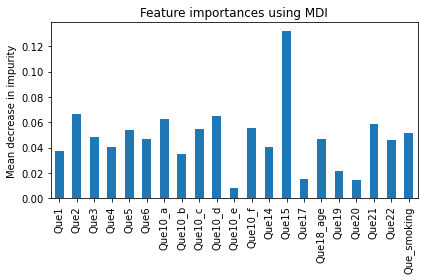

In [29]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:03:57.960450
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 118}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.6825451271277279
Test accuracy:	 0.679814385150812
Test precision:	 0.8183716075156576
Test recall:	 0.6746987951807228
Test F1 score:	 0.7396226415094339
Test confusion matrix:	
[[194  87]
 [189 392]]
Elapsed time to compute the importances: 0.979 seconds


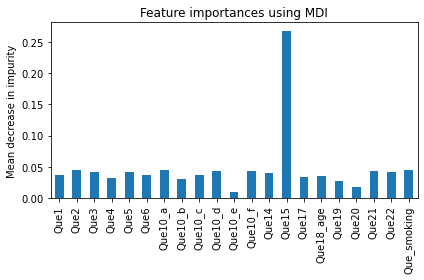

In [30]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:06:01.116521
{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 64,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 87}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.6749376764812172
Test accuracy:	 0.7215777262180975
Test precision:	 0.7846410684474123
Test recall:	 0.8089500860585198
Test F1 score:	 0.7966101694915254
Test confusion matrix:	
[[152 129]
 [111 470]]
Elapsed time to compute the importances: 0.629 seconds


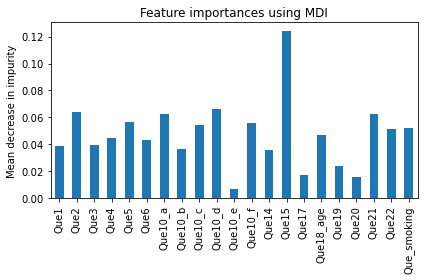

In [31]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
Grid search time: 0:04:04.231588
{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 28,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 56}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.6804748225234442
Test accuracy:	 0.6844547563805105
Test precision:	 0.8121212121212121
Test recall:	 0.6919104991394148
Test F1 score:	 0.7472118959107806
Test confusion matrix:	
[[188  93]
 [179 402]]
Elapsed time to compute the importances: 0.215 seconds


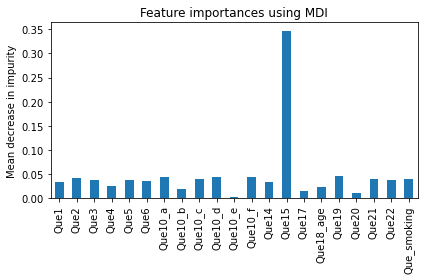

In [32]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [35]:
perform_decision_tree(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:02.179880
{'criterion': 'gini',
 'max_depth': 34,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.6567490092551191
Test accuracy:	 0.6995359628770301
Test precision:	 0.7756849315068494
Test recall:	 0.7796901893287436
Test F1 score:	 0.7776824034334765
Test confusion matrix:	
[[150 131]
 [128 453]]


### Undersampling

In [36]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:01.480160
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'splitter': 'random'}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.6584487415855593
Test accuracy:	 0.6473317865429234
Test precision:	 0.8070953436807096
Test recall:	 0.6265060240963856
Test F1 score:	 0.7054263565891473
Test confusion matrix:	
[[194  87]
 [217 364]]


### Oversampling

In [37]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:02.724675
{'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.660598673290008
Test accuracy:	 0.6960556844547564
Test precision:	 0.781305114638448
Test recall:	 0.7624784853700516
Test F1 score:	 0.7717770034843204
Test confusion matrix:	
[[157 124]
 [138 443]]


### SMOTEENN

In [38]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

Fitting 5 folds for each of 504 candidates, totalling 2520 fits
Grid search time: 0:00:01.596812
{'criterion': 'entropy',
 'max_depth': 42,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'splitter': 'random'}
(array([0., 1.]), array([281, 581]))
Test ROC AUC:	 0.6456440913629098
Test accuracy:	 0.6461716937354989
Test precision:	 0.7899159663865546
Test recall:	 0.6471600688468159
Test F1 score:	 0.7114474929044465
Test confusion matrix:	
[[181 100]
 [205 376]]
Optimization terminated successfully.
         Current function value: 0.552867
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.593311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.585403
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.340062
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.545428
         Iteration

/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_19047/1181320327.py", line 10, in fit
  File "/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-p

Optimization terminated successfully.
         Current function value: 0.557525
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.583155
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.310462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.555514
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.607132
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.599050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.396740
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.562971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.339525
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.607990
  

# Strategy 3 - mean

In [91]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_mean = pd.DataFrame(imputer.fit_transform(data))
data_mean.columns = data.columns
data_mean.index = data.index
# mean values are not integer numbers so rounding to int was necessary
data_mean = data_mean.round()
data_mean = perform_mapping(data_mean, questions_map_EN)
model_data = data_mean.drop(columns=['Que16'])
target_data = data_mean['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [92]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.689674175974422
Optimization terminated successfully.
         Current function value: 0.543996
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 3448
Model:                          Logit   Df Residuals:                     3426
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1246
Time:                        17:52:22   Log-Likelihood:                -1875.7
converged:                       True   LL-Null:                       -2142.7
Covariance Type:            nonrobust   LLR p-value:                 1.150e-99
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.3738      0.133     -2.812      0.005   

### Undersampling

In [93]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6844268282203316
Optimization terminated successfully.
         Current function value: 0.603247
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2158
Model:                          Logit   Df Residuals:                     2136
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1297
Time:                        17:52:22   Log-Likelihood:                -1301.8
converged:                       True   LL-Null:                       -1495.8
Covariance Type:            nonrobust   LLR p-value:                 2.794e-69
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0942      0.164     -6.692      0.000  

### Oversampling

In [94]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6903780091695293
Optimization terminated successfully.
         Current function value: 0.596761
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 4738
Model:                          Logit   Df Residuals:                     4716
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.1391
Time:                        17:52:22   Log-Likelihood:                -2827.5
converged:                       True   LL-Null:                       -3284.1
Covariance Type:            nonrobust   LLR p-value:                7.740e-180
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1757      0.110    -10.721      0.000  

### SMOTEENN

In [95]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.8225409836065574
Optimization terminated successfully.
         Current function value: 0.412749
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2440
Model:                          Logit   Df Residuals:                     2418
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.3939
Time:                        17:52:22   Log-Likelihood:                -1007.1
converged:                       True   LL-Null:                       -1661.6
Covariance Type:            nonrobust   LLR p-value:                2.980e-264
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9994      0.226    -13.282      0.000  

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train, y_train, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, X_test, y_train, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

# Strategy 4 - most frequent

In [96]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_most_frequent = pd.DataFrame(imputer.fit_transform(data))
data_most_frequent.columns = data.columns
data_most_frequent.index = data.index
# mean values are not integer numbers so rounding to int was necessary
data_most_frequent = perform_mapping(data_most_frequent, questions_map_EN)
model_data = data_most_frequent.drop(columns=['Que16'])
target_data = data_most_frequent['Que16']
X_train, X_test, y_train, y_test = train_test_split(model_data.values, target_data.values, test_size=0.20, random_state=42)
# balancing data
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
smote_enn = SMOTEENN(random_state=0)
X_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(X_train, y_train)

## Logistic Regression

### No balance

In [97]:
perform_logit(X_train, y_train, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6940232641299089
Optimization terminated successfully.
         Current function value: 0.572859
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 3448
Model:                          Logit   Df Residuals:                     3426
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                 0.07816
Time:                        17:52:29   Log-Likelihood:                -1975.2
converged:                       True   LL-Null:                       -2142.7
Covariance Type:            nonrobust   LLR p-value:                 2.327e-58
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.4589      0.133     -3.445      0.001  

### Undersampling

In [98]:
perform_logit(X_train_rus, y_train_rus, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6408696399415656
Optimization terminated successfully.
         Current function value: 0.634626
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2158
Model:                          Logit   Df Residuals:                     2136
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                 0.08443
Time:                        17:52:29   Log-Likelihood:                -1369.5
converged:                       True   LL-Null:                       -1495.8
Covariance Type:            nonrobust   LLR p-value:                 1.247e-41
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.1962      0.163     -7.337      0.000  

### Oversampling

In [99]:
perform_logit(X_train_ros, y_train_ros, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.6494354813557359
Optimization terminated successfully.
         Current function value: 0.634111
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 4738
Model:                          Logit   Df Residuals:                     4716
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                 0.08517
Time:                        17:52:29   Log-Likelihood:                -3004.4
converged:                       True   LL-Null:                       -3284.1
Covariance Type:            nonrobust   LLR p-value:                5.332e-105
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.2481      0.109    -11.435      0.000  

### SMOTEENN

In [100]:
perform_logit(X_train_smote_enn, y_train_smote_enn, X_test, y_test, X_cols, y_col)

Mean cross-validation score: 
0.7744215795328142
Optimization terminated successfully.
         Current function value: 0.492600
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  Que16   No. Observations:                 2323
Model:                          Logit   Df Residuals:                     2301
Method:                           MLE   Df Model:                           21
Date:                Wed, 01 Sep 2021   Pseudo R-squ.:                  0.2744
Time:                        17:52:29   Log-Likelihood:                -1144.3
converged:                       True   LL-Null:                       -1577.1
Covariance Type:            nonrobust   LLR p-value:                1.082e-169
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.1103      0.223    -13.934      0.000  

/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:614: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/tmp/ipykernel_19047/3596550944.py", line 9, in fit
  File "/home/miroslav/anaconda3/envs/master-env/lib/python3.7/site-pa

Optimization terminated successfully.
         Current function value: 0.562348
         Iterations 7
         Current function value: 0.592141
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.590595
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547087
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.609072
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.606529
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.539767
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.602560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.598443
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.420418
         Iterations 6
Optimization ter

## Random Forest

### No balance

In [ ]:
perform_random_forest(X_train_smote_enn, y_train_smote_enn, X_test, y_test)

### Undersampling

In [ ]:
perform_random_forest(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_random_forest(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_random_forest(X_train, X_test, y_train, y_test, balance='smoteen')

## Decision Tree

### No balance

In [ ]:
perform_decision_tree(X_train, X_test, y_train, y_test)

### Undersampling

In [ ]:
perform_decision_tree(X_train_rus, y_train_rus, X_test, y_test)

### Oversampling

In [ ]:
perform_decision_tree(X_train_ros, y_train_ros, X_test, y_test)

### SMOTEENN

In [ ]:
perform_decision_tree(X_train_smote_enn, y_train_smote_enn, X_test, y_test)